# 고급기능
단순한 페이지 로딩이 아닌 서버 사이즈 로직과 상호작용하는 다양한 속성들에 대해 알아보자.

## 1. model 정보 생성

Django 는 ORM 타입의 DBMS 를 지원하는 프레임워크로 Model 생성은 테이블 생성과 관리 모두에게 중요한 객체로 존재하고 있다.

**정의가능 타입**
https://www.webforefront.com/django/modeldatatypesandvalidation.html

```python
genders = (
        ("M", "Male"),
        ("F", "Female"),
        ("NB", "Non-binary"),
        ("T", "Transgender"),
        ("I", "Intersex"),
        ("O", "Other"),
        ("PNTS", "Prefer not to say")
    )
```

[주요항목]
- models.CharField(max_length = 200)
- models.CharField(max_length = 50, choices = genders)
- models.IntegerField(default = 0)
- models.DateTimeField(auto_now_add = True)
- models.EmailField()

[그외 다수]
- models.FloatField()
- models.BinaryField()
- models.BooleanField()
- models.DateField()
- models.DateTimeField()

#### 1.1 models.py 는 아래와 같이 모델을 정의 할 수 있다.

```python
from django.db import models
from django.utils import timezone
from django.contrib.auth.models import User

# 단위테이블은 class 로 정의한다.
class Post(models.Model):
    # 클래스 내부에는 각 속성을 정의한다.
    title = models.CharField(max_length=100)
    content = models.TextField()
    
    # 참조키가 존재하는 경우 해당 모델을 import 하여 사용한다.
    author = models.ForeignKey(User, on_delete=models.CASCADE)
    
    # 데이트타임과 같은 시스템 time 을 이용할 수도 있다.
    date_posted = models.DateTimeField('date published') # 'date published'/default=timezone.now()
    
    # 객체 출력시 오브젝트 주소가 아닌 값을 보여주기 위하여 __str__ 내부함수를 오버라이딩 한다.
    def __str__(self):
        return self.title
```

#### 1.2 정의된 모델의 생성 스크립트를 생성한다.
```python
python manage.py makemigrations [APP]
```

#### 1.3 생성 스크립트를 적용 시킨다.
```python
python manage.py migrate [APP]
```

#### 1.4 적용 스크립트를 확인 할 수 있다.
```python
python manage.py sqlmigrate [APP] [REVISION]
```

## 2. ORM Queries
ORM 에서의 질의 방식에 대해 정리해본다.

### 2.1 SELECT

#### 2.1.1 Views 파일 내 Models 객체 사용선언
```python
from .models import Post
```

#### 2.1.2 전체 조회
```python
    Post.objects.all()
```

#### 2.1.3 조건 조회
```python
    Post.objects.filter(author='sample')
    Post.objects.all().filter(author='sample')
```

#### 2.1.4 멀티 조건 조회
**Chaining Filters 방식**
```python
    Post.objects.filter(
        author__startwith='sample' # 작성자가 sample 이면서
    ).exclude(
        date_posted__gte=datetime.date.today() # 오늘이후 등록 건 제외
    ).filter(
        date_posted__gte=datetime.date.(2005,1,30) # 2005-01-30 이후 등록 건
    )
```
**Filtered  QuerySets 방식**
- 3번의 DB 트랜잭션이 발생되는 방식이다.

```python
    q1 = Post.objects.filter( author__startwith='sample' ) # 작성자가 sample 로 시작하면서 
    q2 = q1.exclude( date_posted__gte=datetime.date.today() ) # 오늘 이후 등록 건 제외
    q3 = q2.filter( date_posted__gte=datetime.date.(2005,1,30) ) # 2005-01-30 이후 등록 건
```
- 아래와 같이 선언 하면 한번의 트랜잭션으로 필터링 가능하다.
```python
    q = Post.objects.filter( author__startwith='sample') # 작성자가 sample 이면서 
    q = q.exclude( date_posted__gte=datetime.date.today()) # 오늘 이후 등록 건 제외
    q = q.filter( date_posted__gte=datetime.date.(2005,1,30) ) # 2005-01-30 이후 등록 건
    print(q)
```

#### 2.1.5 PK 기준 단건 조회
- 단건 조회는 해당 데이터가 미존재시 **[Models].DoesNotExist** 예외가 발생된다.  
- 반대로 1건 이상의 데이터가 조회 될 시에는 **[Models].MultipleObjectsReturned** 예외가 발생된다.

```python
    one_entry = Post.objects.get(pk=1)
```

##### 2.1.6 복수건 조회
전체 혹은 필터 그리고 지정된 카운트 만큼 선택하여 조회 할 수 있다.

```python
    Post.objects.all()[:5]
    Post.objects.all()[5:10]
    Post.objects.order_by('author')[0:3]
```

### 2.2 QuerySet API

#### 2.2.0 extra
SQL 구문을 직접 지정하여 사용할 수 있다. 하지만 사용시 SQL Injection 의 위험이 발생 가능하므로 권장 하지 않는다.
```python
qs.extra(
...     select={'val': "select col from sometable where othercol = %s"},
...     select_params=(someparam,),
... )

qs.annotate(val=RawSQL("select col from sometable where othercol = %s", (someparam,)))
```

#### 2.2.1 order_by()
객체 요소들을 정렬시킨다.(None:asending, -:desending)
```python
    Post.objects.filter(author='sample').order_by('-date_posted', 'title')
```
#### 2.2.2 filter
모델에서 특정 조건별로 데이터를 추출하여 리턴 시킨다.
조금 더 복잡한 쿼리를 원할 경우 Q Objects (Query-related tools) 를 사용하여 추가 정의가능하다.


#### 2.2.3 exclude
모델에서 특정 조건을 만족하지 않는 데이터를 추출하여 리턴 시킨다.
```python
    Post.objects.exclude(date_posted__gt=datetime.date(2020, 1, 1), author='sample')
```

#### 2.2.4 annotate
쿼리셋에 적용가능한 쿼리표현식이다. 간단한 집계 함수를 적용하여, 임시변수 또는 지정 변수에 대입 가능 하다.
```python
    p = Post.objects.annotate(number_of_entries=Count('post'))
    p[0].number_of_entries
    >>> 42
```

#### 2.2.5 역정렬
쿼리셋 데이터를 역순으로 정렬 할 수 있다.
```python
p.reverse()[:5]
```

#### 2.2.6 중복제거
컬럼값 을 기준으로 중첩되는 내용을 제거 한다.
```python
Entry.objects.order_by('author', 'pub_date').distinct('author', 'pub_date')
```

#### 2.2.7 유니온
같은 포뮬라 쿼리셋 복수개를 하나로 합칠 수 있다.
```python
qs1.union(qs2, qs3)
```

#### 2.2.8 카운트
데이터베이스내의 카운트 정보를 리턴한다.
```python
Post.objects.count()
Post.objects.filter(author__contains='sample').count()
```

#### 2.2.9 집계 
집계합수를 적용하여 임시변수에 대입한다.
```python
Post.objects.aggregate(Count('author'))
{'author__count': 16}
```

#### 2.2.10 Exists
쿼리셋의 데이터가 존재하는지를 확인하는 함수
```python
if some_queryset.exists():
    print("There is at least one object in some_queryset")

Which will be faster than:
if some_queryset:
    print("There is at least one object in some_queryset")
```

#### 2.2.11 Q객체를 이용한 AND 와 OR 조건의 사용
Query relation tool 인 Q 객체를 이용하면 filter 메서드 체이닝 없이 복수 조건을 적용 할 수 있다.
```python
from django.db.models import Q
Post.objects.filter(Q(author='sample') & Q(posted_date=datetime.date.today()))
# 이하와 동일 SELECT ... WHERE author='sample' AND posted_date=SYSDATE

Post.objects.filter(Q(author='sample') | Q(posted_date=datetime.date.today()))
# 이하와 동일 SELECT ... WHERE author='sample' OR posted_date=SYSDATE
```

### 2.3 등록, 수정, 삭제

#### 2.3.1 객체의 생성 (신규등록)
해당 테이블에 신규 데이터 등록은 아래와 같다.

```python
    p = Post.objects.create(author='sample', title = 'title', content='samples content')
    
    p = Post(author='sample', title = 'title', content='samples content')
    p.save(force_insert=True)
```

#### 2.3.2 객체의 수정 (업데이트)
해당 테이블에 데이터 수정은 아래와 같다.

```python
    Post.objects.filter(title = 'title').filter(author='sample').update(author='TestUser')
    
    # 아래와 같은 기술은 동작하지 않는다. 꼭 필터조건이 필요하다.
    Post.objects.update(author='TestUser')
    
    # uid 를 지칭 하는것도 방법
    Post.objects.filter(id=1).update(author='TestUser')
```

#### 2.3.3 벌크 생성
입력된 데이터를 하나의 커밋 카운트로 등록 시킨다. 정상 처리후 등록 순서대로 데이터가 리턴 된다.
```python
    objs = Post.objects.bulk_create([
        Post(author='sample', title = 'title1', content='samples content1'),
        Post(author='sample', title = 'title2', content='samples content2'),
        Post(author='sample', title = 'title3', content='samples content3'),
    ])
```

#### 2.3.4 벌크 업데이트
입력된 데이터를 하나의 커밋 카운트로 수정 시킨다. 정상 처리후 수정 순서대로 데이터가 리턴 된다.
```python
    objs = Post.objects.bulk_update([
        Post(author='sample', title = 'title1', content='This samples content1'),
        Post(author='sample', title = 'title2', content='This samples content2'),
        Post(author='sample', title = 'title3', content='This samples content3'),
    ], ['content'])
```

#### 2.3.5 삭제
수정과 마찬가지로 필터 조건을 필요로 한다. 단, 전체 삭제의 경우 아래와 같이 처리 가능하다.
```python
    # 단건 삭제
    b = Blog.objects.get(pk=1)
    Entry.objects.filter(blog=b).delete()
    
    # 복수건 삭제
    blogs = Blog.objects.all()
    blogs.delete()
```

### 2.4 쿼리표현식 (Query Expressions)
속성id + __ + 조작어 순으로 조립하여 사용 ex) money__gt = 10000

- gt  : greater than.
- gte : grater than or equals to.
- lt : less than.
- lte : less than or equals to.
- startwith : case-sensitive start-with.
- isstartwith : case-sensitive start-with.
- range : range(from, to)
- date : pub_date__date (pub_date 필드의 특정 일자 만)
- year : pub_date__year (pub_date 필드의 특정 년도 만)
- month : pub_date__month (pub_date 필드의 특정 월 만)
- day : pub_date__day (pub_date 필드의 특정 일 만)
- isnull : isnull

## 3. base 템플릿 적용
원페이지 사이트를 구성하기 위해서는 각 프레임별 컴포넌트가 고정적으로 동작해야 할 필요가 있다. 때문에 컨텐츠 부분을 제외한 나머지를 base.html 로 정의하고 이를 컨텐츠 페이지의 상단과 하단에 첨부되도록 html 을 작성 하여 본다.

In [4]:
# base.html 작성 내용
!cat ../blog/templates/blog/base.html

{% load static %}
<!doctype html>
<html lang="en">
  <head>
    <!-- Required meta tags -->
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no">

    <!-- Bootstrap CSS -->
    <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/css/bootstrap.min.css" integrity="sha384-Gn5384xqQ1aoWXA+058RXPxPg6fy4IWvTNh0E263XmFcJlSAwiGgFAW/dAiS6JXm" crossorigin="anonymous">
	<link rel="stylesheet" type="text/css" href="{% static 'blog/main.css' %}">
	
	{% if title %}
		<title>Django Blog - {{ title }}</title>
	{% else %}
		<title>Django Blog</title>
	{% endif %}
  </head>
  <body>
  <!-- navigation bar start -->
  <header class="site-header">
	  <nav class="navbar navbar-expand-md navbar-dark bg-steel fixed-top">
		<div class="container">
		  <a class="navbar-brand mr-4" href="/">100 Goon's Blog</a>
		  <button class="navbar-toggler" type="button" data-toggle="collapse" data-target="#navbarToggle" aria-controls="

### 커스텀 태그 설명
- {{ title }} : title 변수사용
- {% block content %}{% endblock %} : 컨텐츠가 포함되는 영역이다.
- {% if title %} {% else %} {% endif %} : 조건절의 사용과 종료
- {% for message in messages %} {% endfor %} : 반복문의 사용과 종료	
- {% load static %} : static 폴더 로드
- {% extends "blog/base.html" %} : 이미 작성된 base.html 내 컨텐츠 블록을 삽입

In [5]:
### base.html 이 적용된 컨텐츠 페이지 확인
!cat ../blog/templates/blog/home.html

{% extends "blog/base.html" %}
{% block content %}
	{% for post in posts %}
		<article class="media content-section">
		  <div class="media-body">
			<div class="article-metadata">
			  <a class="mr-2" href="#">{{ post.author }}</a>
			  <small class="text-muted">{{ post.date_posted|date:"F d, Y" }}</small>
			</div>
			<h2><a class="article-title" href="#">{{ post.title }}</a></h2>
			<p class="article-content">{{ post.content }}</p>
		  </div>
		</article>
	{% endfor %}
{% endblock content %}


## 3. 사용자정의 FORM 작성

Django 에서는 회원가입 입력 양식등을 Forms 이라는 객체로 컨트롤 하고 있다.  
Form 은 입력 폼과 포맷, 검증등을 선언만으로 적용 가능하며, 사용자 정의 Form 형태로도 선언하여 사용 가능하다.

**회원가입 폼의 구성요소**
- [Forms.py 정의] : 입력 양식에 해당하는 Forms 을 미리 정의한다.
- [Register.html-Form] <-> [View-Register-Form]  <-> [Redirect Page 호출]

#### 3.1 회원 가입 프로세스를 위해 APP 을 신규 추가 한다.
```python
!python manage.py startapp users
```

In [8]:
# UsersConfig 를 App 에 추가한다.
!head -30 ../config/settings.py

from pathlib import Path

# Build paths inside the project like this: BASE_DIR / 'subdir'.
BASE_DIR = Path(__file__).resolve().parent.parent


# Quick-start development settings - unsuitable for production
# See https://docs.djangoproject.com/en/3.2/howto/deployment/checklist/

# SECURITY WARNING: keep the secret key used in production secret!
SECRET_KEY = 'django-insecure-^-o$e^lif^tcq08r2&ubj20j91!j77o-)j6!nfrl+l5w8vd=l^'

# SECURITY WARNING: don't run with debug turned on in production!
DEBUG = True

ALLOWED_HOSTS = []


# Application definition

INSTALLED_APPS = [
    'django.contrib.admin',
    'django.contrib.auth',
    'django.contrib.contenttypes',
    'django.contrib.sessions',
    'django.contrib.messages',
    'django.contrib.staticfiles',
    'polls.apps.PollsConfig', # added new apps config class
    'blog.apps.BlogConfig', # added new apps config class
    'users.apps.UsersConfig', # added new users config class


#### 3.2 Views 작성

회원 가입 요청에 대응 하기 위한 View 를 작업한다.  
View-register 를 호출 하는 경우는, 회원가입 창을 그냥 방문 하는 경우와 등록 서비스를 실행한 경우 두가지로 나눌 수 있다.

In [14]:
# 회원가입이 목적인 경우에는 UserCreationForm 을 작성하여 register.html 로
!cat ../users/views.py

from django.shortcuts import render, redirect
from django.contrib.auth.forms import UserCreationForm
from django.contrib import messages
from .forms import UserRegisterForm

def register(request):
    if request.method == 'POST':
        form = UserCreationForm(request.POST)
        if form.is_valid():
            form.save()
            username = form.cleaned_data.get('username')
            messages.success(request, f'Account created for {username}!')
            return redirect('blog-home')
    else:
        form = UserCreationForm()
    return render(request, 'users/register.html', {'form':form})


#### 3.3 register.html 작성

사용자가 작성한 데이터를 전송하는 Form 을 구성한다.

- {% csrf_token %} : form내 선언 만으로 입력값의 유효성을 검증하여 준다.
- {{ form.as_p }} : form 의 구성요소를 모두 p 태그로 감싼 html 문서를 생성하여 준다.

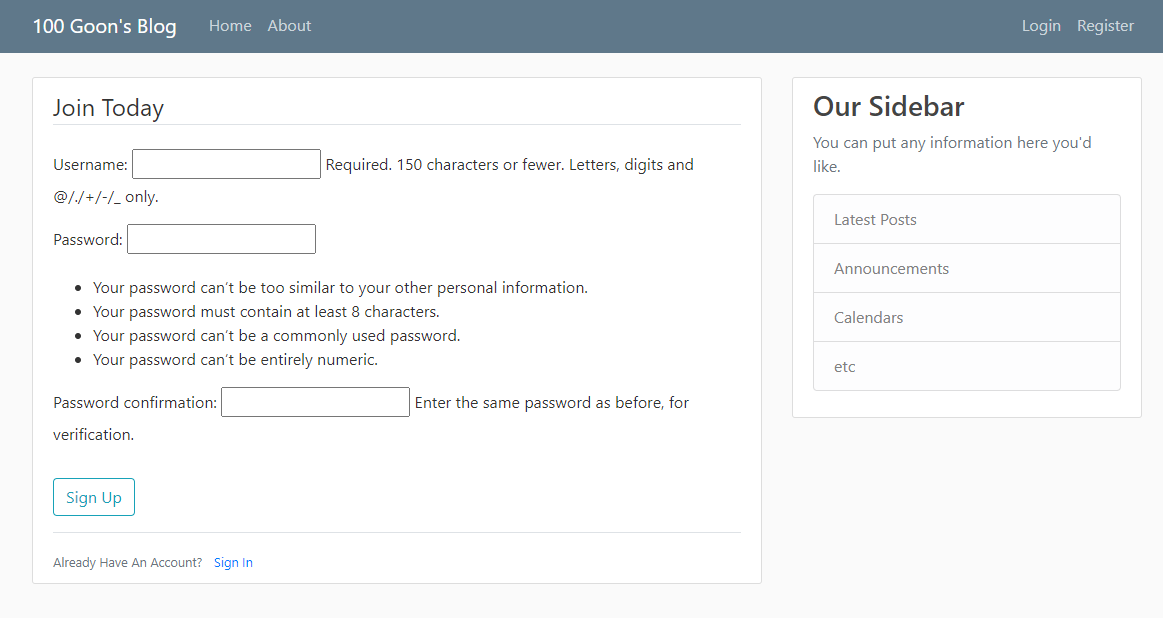

In [15]:
# form 메소드의 엔드포인트는 django 가 자동으로 난독화하여 값을 채워준다.
!cat ../users/templates/users/register.html

{% extends "blog/base.html" %}
{% block content %}
	<div class="content-section">
		<form method="POST">
			{% csrf_token %}
			<fieldset class="form-group">
				<legend class="border-bottom mb-4">Join Today</legend>
				{{ form.as_p }}
			</fieldset>
			<div class="form-group">
				<button class="btn btn-outline-info" type="submit">Sign Up</button>
			</div>
		</form>
		<div class="border-top pt-3">
			<small class="text-muted">
				Already Have An Account? <a class="ml-2" href="#">Sign In</a>
			</small>
		</div>
	</div>
{% endblock content %}


#### 3.4 사용자 정의 FORM 작성
기존 항목외 추가 가능한 항목을 정의하여 선언하기만 하면 화면과 View 에 자동으로 추가된다.

- 작업내용 : email 항목을 추가한다.
- 메타정보를 선언 한다. (inner class 로 정의하여 상위 클래스에게 meta data 를 제공하는 기능)  
  ex) 아래 class Meta 에 기술된 model 에 값을 차례대로 대입 하여. save() 와 Model 함수를 적용할 수 있다.

In [20]:
# 사용자 정의 FORM 확인 - UserCreationForm 을 상속 받아 처리한다. 
!cat ../users/forms.py

from django import forms
from django.contrib.auth.models import User
from django.contrib.auth.forms import UserCreationForm

class UserRegisterForm(UserCreationForm):
    email = forms.EmailField()
    sample = forms.IntegerField()
    
    class Meta:
        model = User
        fields = ['username', 'email', 'password1', 'password2']


#### 사용자 정의 입력 폼대로 화면에 랜더링 된다.

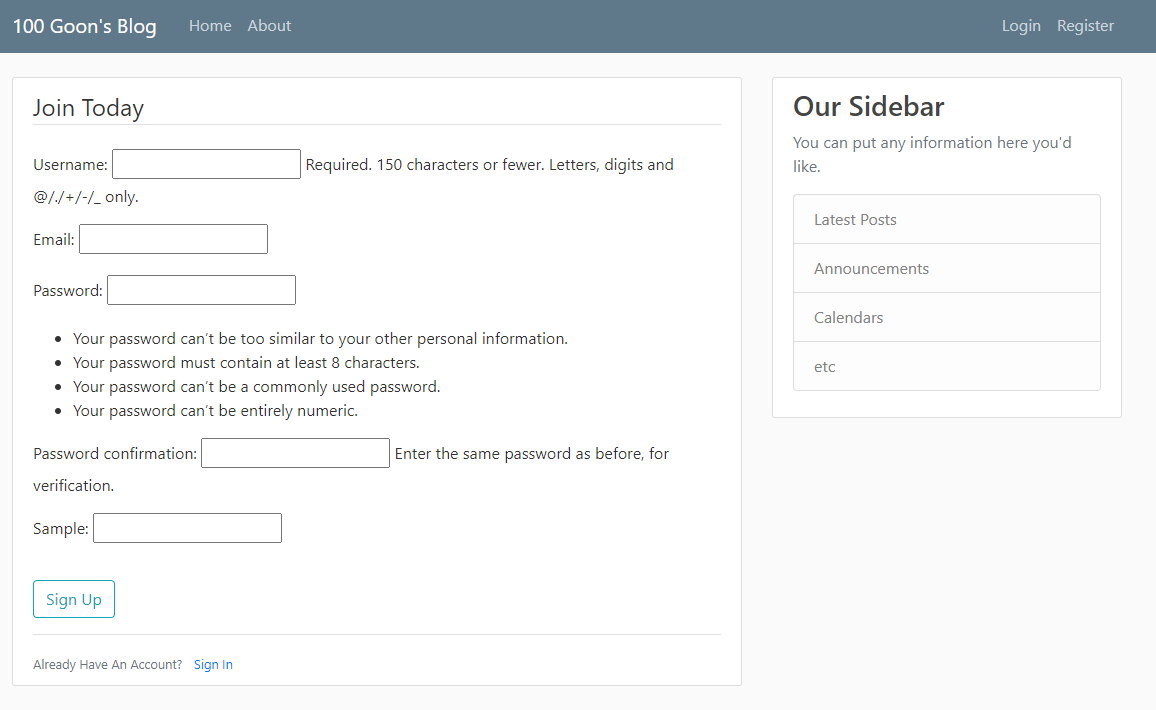

#### 3.5 부트스트랩 django-crispy-forms 설치

1. 아래 명령어를 통해 모듈을 설치한다.

```python
!pip install django-crispy-forms
```

2. 프로젝트 settings.py 에도 APP을 추가한다.
```python
'crispy_forms',
```

3. STATIC_URL 아래에 CRISPY_TEMPLATE_PACK 을 정의한다.
```python
CRISPY_TEMPLATE_PACK = 'bootstrap4'
```

In [25]:
!head -25 ../config/settings.py

from pathlib import Path

# Build paths inside the project like this: BASE_DIR / 'subdir'.
BASE_DIR = Path(__file__).resolve().parent.parent


# Quick-start development settings - unsuitable for production
# See https://docs.djangoproject.com/en/3.2/howto/deployment/checklist/

# SECURITY WARNING: keep the secret key used in production secret!
SECRET_KEY = 'django-insecure-^-o$e^lif^tcq08r2&ubj20j91!j77o-)j6!nfrl+l5w8vd=l^'

# SECURITY WARNING: don't run with debug turned on in production!
DEBUG = True

ALLOWED_HOSTS = []


# Application definition

INSTALLED_APPS = [
    'polls.apps.PollsConfig', # added new apps config class
    'blog.apps.BlogConfig', # added new apps config class
    'users.apps.UsersConfig', # added new apps config class
    'crispy_forms', # added new apps config class


In [27]:
# register.html 에 {% load crispy_forms_tags %} 을 설정한다.
!head -5 ../users/templates/users/register.html

{% extends "blog/base.html" %}
{% load crispy_forms_tags %}
{% block content %}
	<div class="content-section">
		<form method="POST">


#### 부트스트랩 적용 결과로 화면이 아래와 같이 개선 되었다.

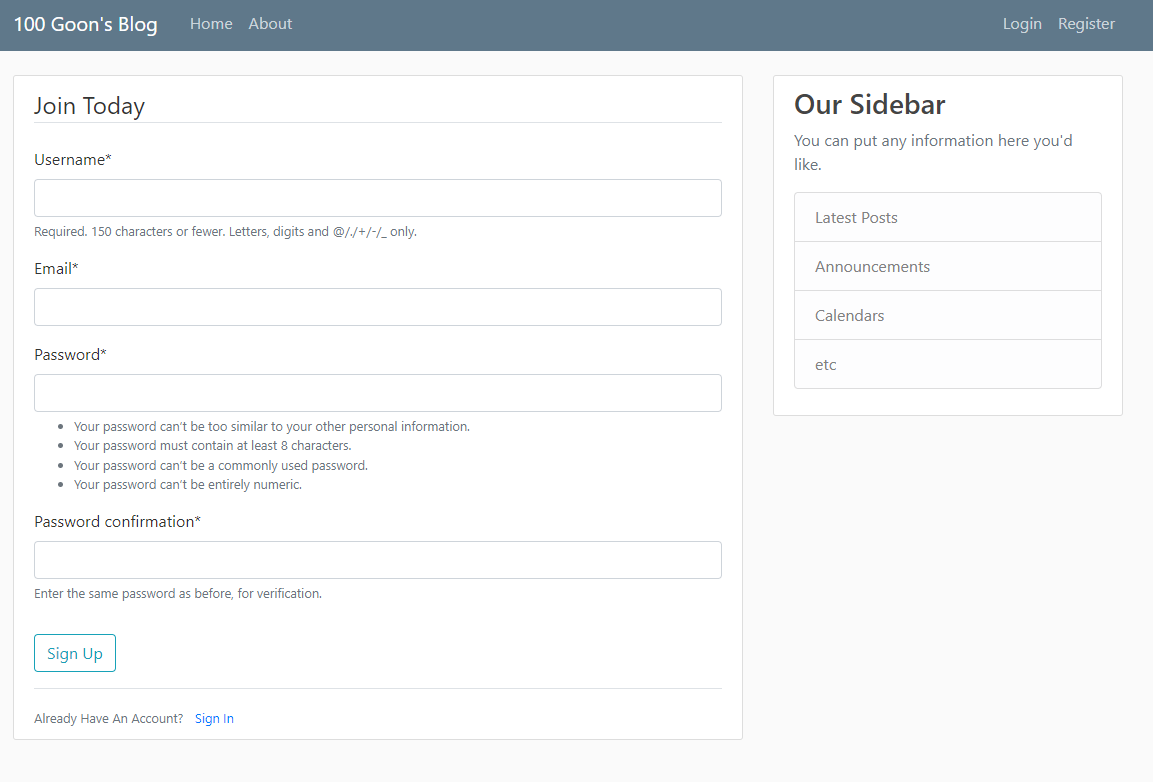